# Differential Expression with limma-voom pipeline - Genes

In [1]:
suppressMessages({library(ggplot2)
                  library(limma)
                  library(edgeR)
                  library(sva)
                  library(dplyr)
                  library(data.table)})

## Prepare Data

In [49]:
pheno_file = '/ceph/users/jbenja13/projects/sex_sz_ria/input/commonMind/phenotypes/combine_files/_m/CMC_phenotypes_all.csv'
pheno = read.csv(pheno_file, stringsAsFactors = F) %>% 
    filter(Dx %in% c('Control', 'SCZ'),
           Age.of.Death > 17, Sex %in% c('XX', 'XY'))
pheno[1:2, 1:10]
dim(pheno)

,Individual_ID,RNAseq.Sample_RNA_ID,Genotypes.Genotyping_Sample_ID,Institution,Dx,Reported.Gender,Sex,Ethnicity,Brain.Weight..in.grams.,PMI..in.hours.
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,CMC_HBCC_003,CMC_HBCC_RNA_PFC_3158,4040296003_A,NIMH-HBCC,Control,Male,XY,Caucasian,1500,13
2,CMC_HBCC_006,CMC_HBCC_RNA_PFC_3162,4572348358_R01C02,NIMH-HBCC,Control,Male,XY,African-American,1250,44


[1] 814  47

### Load genotype data

In [50]:
mds_file = '/ceph/users/jbenja13/projects/sex_sz_ria/input/commonMind/genotypes/mds/_m/CMC_MSSM-Penn-Pitt_DLPFC_QC.mds'
mds = fread(mds_file, data.table=F)
colnames(mds) = gsub('C', 'snpPC', colnames(mds))
head(mds)

,FID,IID,SOL,snpPC1,snpPC2,snpPC3,snpPC4,snpPC5,snpPC6,snpPC7,snpPC8,snpPC9,snpPC10
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,MSSM_13,0,-0.02226900,-0.00960189,0.00398743,0.000288773,-0.002412270,0.003863710,-0.00645592,2.05686e-05,-0.003564570,0.003195170
2,0,MSSM_25,0,-0.02111640,-0.00721966,0.00368005,-0.002035680,0.000947013,0.002865670,0.00380275,-8.09738e-04,0.002788260,0.000883054
3,0,MSSM_48,0,-0.01533570,0.02725110,-0.00141831,-0.001310480,-0.007791530,0.000903945,0.00386361,-9.29096e-04,0.000432877,0.002867700
4,0,MSSM_59,0,-0.01580840,0.01177670,0.00187047,0.003407890,0.015133700,-0.011008300,-0.00251472,1.15840e-03,-0.004319110,-0.003293370
5,0,MSSM_83,0,0.00730839,-0.00423147,-0.03097030,0.016012400,0.002320820,-0.000923755,0.00224721,9.01862e-03,0.000747573,0.001278140
6,0,MSSM_2,0,-0.01586000,0.02460900,-0.00221120,-0.001457290,-0.005850930,0.002230790,0.00103045,1.68320e-03,-0.000216837,0.001251180


In [51]:
new_pheno = merge(pheno, mds, by.y='IID', by.x='Genotypes.Genotyping_Sample_ID')
new_pheno$Dx = factor(new_pheno$Dx, levels = c("Control", "SCZ"))
new_pheno$Sex <- factor(new_pheno$Sex)
head(new_pheno, 2)

,Genotypes.Genotyping_Sample_ID,Individual_ID,RNAseq.Sample_RNA_ID,Institution,Dx,Reported.Gender,Sex,Ethnicity,Brain.Weight..in.grams.,PMI..in.hours.,⋯,snpPC1,snpPC2,snpPC3,snpPC4,snpPC5,snpPC6,snpPC7,snpPC8,snpPC9,snpPC10
,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<fct>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,MSSM_1,CMC_MSSM_025,MSSM_RNA_PFC_1,MSSM,SCZ,Male,XY,Caucasian,1216,8.9,⋯,-0.02072340,-0.00621056,0.00332806,0.000395088,0.00398844,-0.00191427,-0.00683373,-0.000160904,-0.00162913,-0.00323322
2,MSSM_10,CMC_MSSM_026,MSSM_RNA_PFC_10,MSSM,Control,Male,XY,Hispanic,1238,12.3,⋯,-0.00419867,-0.01177810,-0.08272160,0.019969900,-0.01176620,0.00431321,0.00633604,-0.009369610,-0.00082994,-0.00336866


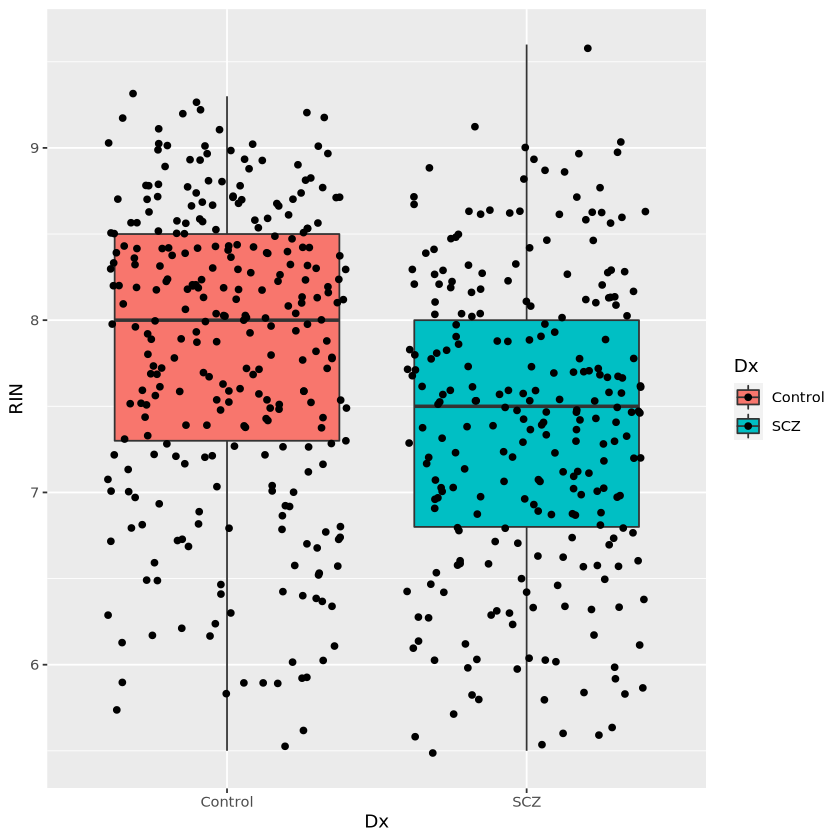

In [52]:
ggplot(new_pheno, aes(x=Dx, y=RIN, fill=Dx)) + geom_boxplot() + geom_jitter()

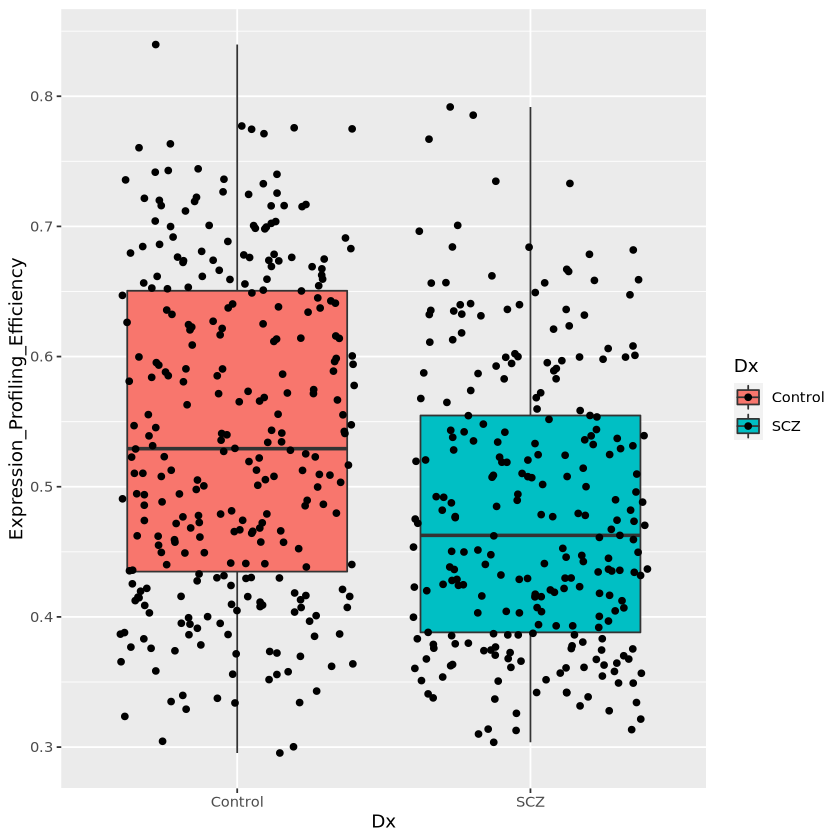

In [53]:
ggplot(new_pheno, aes(x=Dx, y=Expression_Profiling_Efficiency, fill=Dx)) + geom_boxplot() + geom_jitter()

In [54]:
table(new_pheno$Dx)


Control     SCZ 
    292     253 

In [55]:
table(new_pheno$Brodmann_Area)


  9  46 
543   2 

In [56]:
new_pheno = new_pheno %>% 
            mutate(Age=replace(new_pheno$Age.of.Death, new_pheno$Age.of.Death == '90+', '91')) %>% 
            filter(Brodmann_Area == '9')
new_pheno$Age = as.numeric(new_pheno$Age)

### Load gene counts

In [57]:
counts_file = '/ceph/users/jbenja13/projects/sex_sz_ria/input/commonMind/counts/_m/CMC_MSSM-Penn-Pitt_DLPFC_rsem_genes_expected_count.tsv'
counts = fread(counts_file, data.table=FALSE)
rownames(counts) = counts[, 1]
counts[1:5, 1:5]

,gene_id,transcript_id.s.,MSSM_RNA_BP_PFC_2,MSSM_RNA_BP_PFC_4,MSSM_RNA_BP_PFC_5
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
ENSG00000000003.14,ENSG00000000003.14,"ENST00000373020.8,ENST00000494424.1,ENST00000496771.5,ENST00000612152.4,ENST00000614008.4",159.00,113.00,175.00
ENSG00000000005.5,ENSG00000000005.5,"ENST00000373031.4,ENST00000485971.1",2.00,1.00,1.00
ENSG00000000419.12,ENSG00000000419.12,"ENST00000371582.8,ENST00000371584.8,ENST00000371588.9,ENST00000413082.1,ENST00000466152.5,ENST00000494752.1",347.00,203.00,258.00
ENSG00000000457.13,ENSG00000000457.13,"ENST00000367770.5,ENST00000367771.10,ENST00000367772.8,ENST00000423670.1,ENST00000470238.1",312.63,201.33,259.89
ENSG00000000460.16,ENSG00000000460.16,"ENST00000286031.10,ENST00000359326.8,ENST00000413811.3,ENST00000459772.5,ENST00000466580.6,ENST00000472795.5,ENST00000481744.5,ENST00000496973.5,ENST00000498289.5",95.37,70.67,93.11


In [58]:
annot = counts[, 1:2]
head(annot, 2)

,gene_id,transcript_id.s.
,<chr>,<chr>
ENSG00000000003.14,ENSG00000000003.14,"ENST00000373020.8,ENST00000494424.1,ENST00000496771.5,ENST00000612152.4,ENST00000614008.4"
ENSG00000000005.5,ENSG00000000005.5,"ENST00000373031.4,ENST00000485971.1"


In [59]:
new_counts = merge(t(counts[, -1:-2]), new_pheno, 
                   by.x=0, by.y='RNAseq.Sample_RNA_ID')
row.names(new_counts) = new_counts[, 'Row.names']
new_counts = new_counts %>% 
    select(-c(colnames(new_pheno)[colnames(new_pheno)!= 'RNAseq.Sample_RNA_ID'], 'Row.names'))
new_counts = t(new_counts)
new_counts[1:2, 1:5]
dim(new_counts)

,MSSM_RNA_PFC_1,MSSM_RNA_PFC_10,MSSM_RNA_PFC_100,MSSM_RNA_PFC_101,MSSM_RNA_PFC_102
ENSG00000000003.14,124,307,242,99,196
ENSG00000000005.5,1,2,1,1,4


[1] 58347   543

### Generate DGEList

In [60]:
x <- DGEList(counts=new_counts, 
             genes=annot, 
             samples=new_pheno)

### Filtering low counts

In [61]:
design0 <- model.matrix(~Dx, data=x$samples)
keep.x <- filterByExpr(x, design=design0)
x <- x[keep.x, , keep.lib.sizes=FALSE]
print(paste('There are:', sum(keep.x), 'features left!', sep=' '))

[1] "There are: 19974 features left!"


### Normalize counts

In [62]:
x <- calcNormFactors(x, method="TMM")

## Differential Expression Analysis

### Design matrix

In [63]:
mod = model.matrix(~Dx + Age + RIN + rRNA_Rate, data = new_pheno)

colnames(mod) <- gsub("Dx", "", colnames(mod))
colnames(mod) <- gsub("\\(Intercept\\)", "Intercept",
                         colnames(mod))

head(mod, 2)

,Intercept,SCZ,Age,RIN,rRNA_Rate
1,1,1,68,7.5,0.0004665723
2,1,0,58,8.8,0.0002741816


### Calculate SVAs

In [64]:
null.model = as.matrix(as.data.frame(mod)[, !(names(as.data.frame(mod)) %in% c("SCZ"))])
head(null.model, 2)

,Intercept,Age,RIN,rRNA_Rate
1,1,68,7.5,0.0004665723
2,1,58,8.8,0.0002741816


In [65]:
print(paste('Determining number of surragate variables ...', Sys.time(), sep=' '))
n.sv <- num.sv(x$counts, mod, method="be")

print(paste('Fitting SV model ...', Sys.time(), sep=' '))
svobj <- svaseq(x$counts, mod, null.model, n.sv=n.sv)

[1] "Determining number of surragate variables ... 2020-08-07 07:56:09"
[1] "Fitting SV model ... 2020-08-07 08:01:15"
Number of significant surrogate variables is:  1 
Iteration (out of 5 ):1  2  3  4  5  

### Merge models

In [66]:
print(paste('Adding SV to design matrix ...', Sys.time(), sep=' '))
modQsva <- cbind(mod, svobj$sv)
len.d <- length(colnames(modQsva))
colnames(modQsva)[((len.d - n.sv)+1):len.d] <- make.names(paste0("sv",1:n.sv))

[1] "Adding SV to design matrix ... 2020-08-07 08:01:50"


### Preform voom

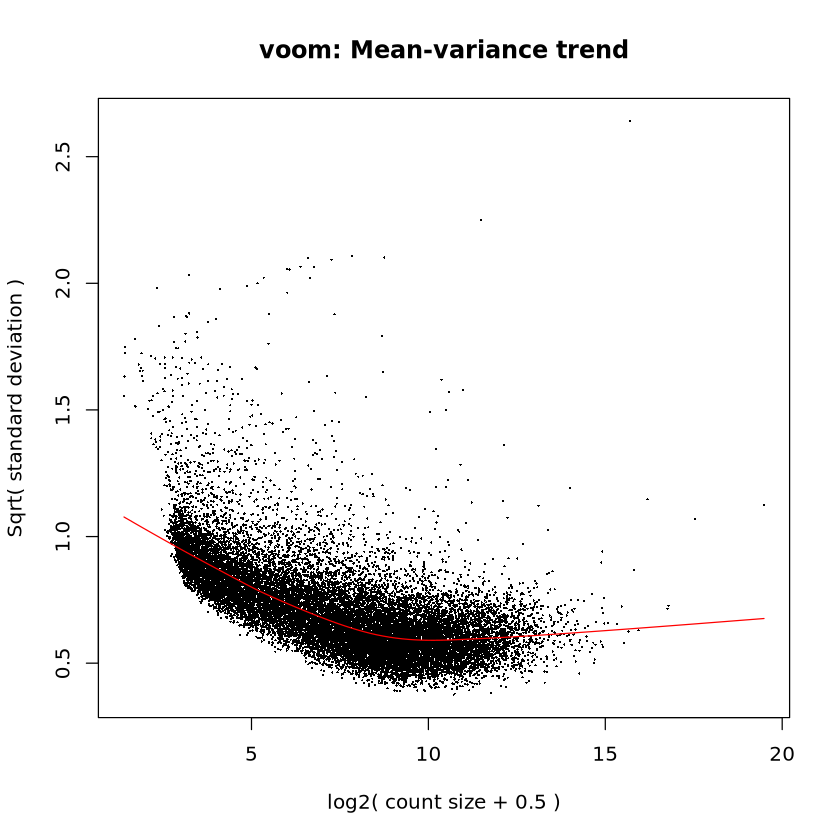

In [67]:
v <- voom(x, modQsva, plot=TRUE)

### Calculate residuals

In [21]:
null_model = as.matrix(as.data.frame(v$design)[, !(names(as.data.frame(v$design)) %in% c("SCZ"))])
fit_res <- lmFit(v, design=null_model)
res = v$E - ( fit_res$coefficients %*% t(null_model) )
res_sd = apply(res, 1, sd)
res_mean = apply(res, 1, mean)

### Normalize residuals and write to file

In [22]:
res_norm = (res - res_mean) / res_sd

In [23]:
feature = 'genes'
dir.create(feature)

save(v, file=paste0(feature,'/voomSVA.RData'))
write.table(res_norm, file=paste0(feature, '/residualized_expression.tsv'), sep="\t", quote=FALSE)

### Fit model with limma

In [68]:
fit0 <- lmFit(v, modQsva)
contr.matrix <- makeContrasts(CtrlvsSZ = SCZ, 
                              levels=colnames(modQsva))
fit <- contrasts.fit(fit0, contrasts=contr.matrix)

### Calculate differential expression with eBayes

In [69]:
esv <- eBayes(fit)

options(width=200)
top0 <- topTable(esv, coef=1, number=Inf, sort.by="P")
sigTest <- decideTests(esv)

top <- merge(top0, sigTest, by=0)
rownames(top) <- top$Row.names
top <- top[,-1]
top <- top[order(top$P.Value), ]
dim(top)

[1] 19974     9

In [32]:
write.table(top, file=paste0(feature, "/diffExpr_szVctl_full.txt"),
            sep='\t', row.names=TRUE, quote=FALSE)

### Subset via FDR

In [70]:
top.fdr <- top[top$adj.P.Val<=0.05,]
print(paste('There are:', dim(top.fdr)[1], 'DE features!'))

[1] "There are: 78 DE features!"


In [35]:
write.table(top.fdr, file=paste0(feature, "/diffExpr_szVctl_FDR05.txt"),
            sep='\t', row.names=TRUE, quote=FALSE)

## Volcano and MA plots

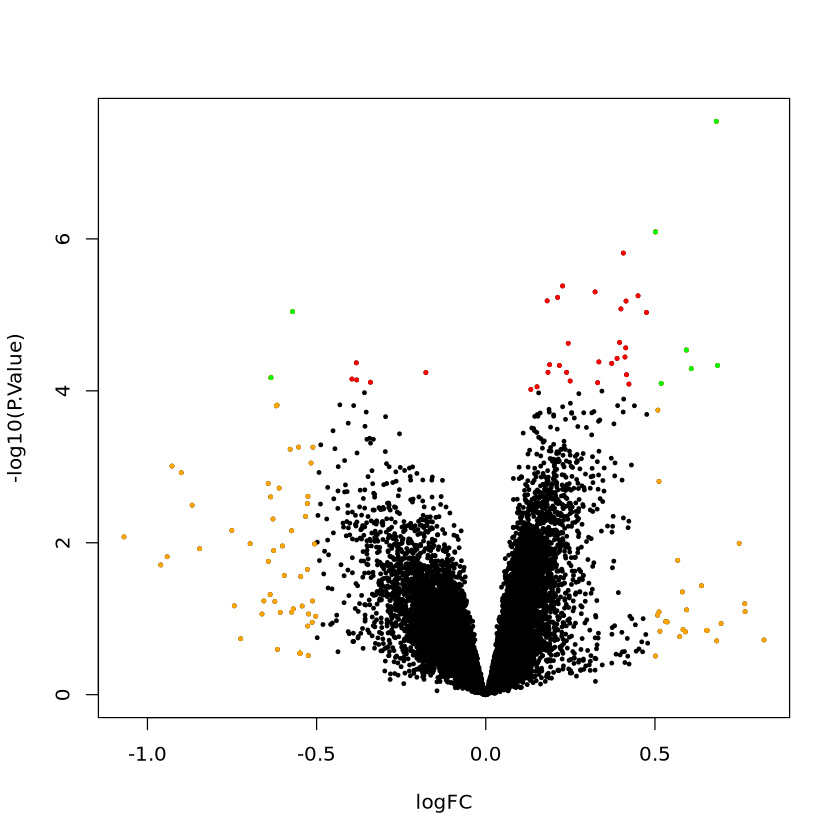

In [27]:
with(top, plot(logFC, -log10(P.Value), pch=20, cex=0.6))
with(subset(top, adj.P.Val<=0.05), points(logFC, -log10(P.Value),
                                          pch=20, col='red', cex=0.6))
with(subset(top, abs(logFC)>0.50), points(logFC, -log10(P.Value),
                                          pch=20, col='orange', cex=0.6))
with(subset(top, adj.P.Val<=0.05 & abs(logFC)>0.50),
     points(logFC, -log10(P.Value), pch=20, col='green', cex=0.6))

In [37]:
pdf(file=paste0(feature, "/volcanoPlot.pdf"), 8, 6)
with(top, plot(logFC, -log10(P.Value), pch=20, cex=0.6))
with(subset(top, adj.P.Val<=0.05), points(logFC, -log10(P.Value),
                                          pch=20, col='red', cex=0.6))
with(subset(top, abs(logFC)>0.50), points(logFC, -log10(P.Value),
                                          pch=20, col='orange', cex=0.6))
with(subset(top, adj.P.Val<=0.05 & abs(logFC)>0.50),
     points(logFC, -log10(P.Value), pch=20, col='green', cex=0.6))
dev.off()

png 
  2

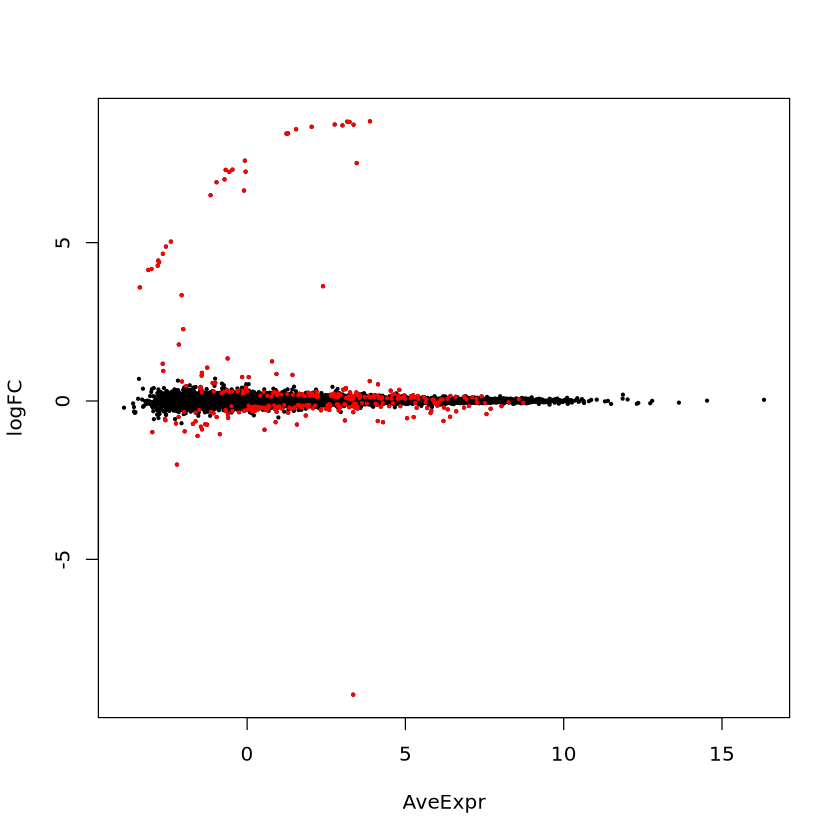

In [24]:
with(top, plot(AveExpr, logFC, pch=20, cex=0.5))
with(subset(top, adj.P.Val<0.05),
     points(AveExpr, logFC, col="red", pch=20, cex=0.5))

In [39]:
pdf(file=paste0(feature, "/MAplot.pdf"), 8, 6)
with(top, plot(AveExpr, logFC, pch=20, cex=0.5))
with(subset(top, adj.P.Val<0.05),
     points(AveExpr, logFC, col="red", pch=20, cex=0.5))
dev.off()

png 
  2

## Repreducibility Information

In [40]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()

[1] "2019-06-06 15:35:17 EDT"

    user   system  elapsed 
3161.182   47.897  287.152 

- Session info -------------------------------------------------------------------------------------------------------
 setting  value                       
 version  R version 3.5.0 (2018-04-23)
 os       Arch Linux                  
 system   x86_64, linux-gnu           
 ui       X11                         
 language (EN)                        
 collate  C                           
 ctype    C                           
 tz       America/New_York            
 date     2019-06-06                  

- Packages -----------------------------------------------------------------------------------------------------------
 package              * version   date       lib source        
 annotate               1.60.0    2018-10-30 [1] Bioconductor  
 AnnotationDbi          1.44.0    2018-10-30 [1] Bioconductor  
 assertthat             0.2.0     2017-04-11 [1] CRAN (R 3.5.0)
 base64enc              0.1-3     2015-07-28 [1] CRAN (R 3.5.0)
 bindr                  0.1.1     2018-03-13 [1] CR